In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm

In [2]:
#list all the data files and its path
files_first = []
onlyfiles = [f for f in listdir('../Data/first_session') if isfile(join('../Data/first_session', f))]
for i in range(len(onlyfiles)):
    path = '../Data/first_session/' + onlyfiles[i]
    files_first.append(path)
files = []
files.append(files_first)
files


[['../Data/first_session/016469_painpred_2023-03-15_11h00.37.704.csv',
  '../Data/first_session/023062_painpred_2023-03-15_12h23.23.337.csv',
  '../Data/first_session/044093_painpred_2023-03-15_09h00.14.401.csv',
  '../Data/first_session/263056_painpred_2023-03-15_11h07.17.314.csv',
  '../Data/first_session/331474_painpred_2023-03-15_11h39.58.101.csv',
  '../Data/first_session/341791_painpred_2023-03-15_20h15.10.055.csv',
  '../Data/first_session/352027_painpred_2023-03-15_10h14.12.834.csv',
  '../Data/first_session/381571_painpred_2023-03-15_10h20.03.575.csv',
  '../Data/first_session/390461_painpred_2023-03-15_19h57.08.597.csv',
  '../Data/first_session/439414_painpred_2023-03-15_11h38.49.835.csv',
  '../Data/first_session/485477_painpred_2023-03-15_11h26.02.146.csv',
  '../Data/first_session/586385_painpred_2023-03-15_13h02.40.178.csv',
  '../Data/first_session/611614_painpred_2023-03-15_12h07.19.577.csv',
  '../Data/first_session/643004_painpred_2023-03-15_14h38.22.757.csv',
  '../

# Preprocessing Functions
For windowing, I realise the reaction time is always the longest in the first trial. So I think we could window more (start from 6 seconds) for the first trial?

In [3]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list

    

def lowpass_butter(rating, time, cutoff, order=5):
    lowpass_list = [] #list for all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]-time[i][0]
            fs = N/T
            nyq = fs*0.5
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            y = filtfilt(b, a, rating[i])
            lowpass_list.append(y)
        else:
            lowpass_list.append([np.NaN])
    return lowpass_list
        


def exponential_smoothing_trial(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def exponential_smoothing(rating, alpha):
    lowpass_list = [] #list of all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = [rating[i][0]] # first value is same as series
            for n in range(1, len(rating[i])):
                result.append(alpha * rating[i][n] + (1 - alpha) * result[n-1])
            lowpass_list.append(result)
        else:
            lowpass_list.append([np.nan])
    return lowpass_list


        
    

# Analysis Functions

In [4]:
#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#autocorrelation
def autocorrelation(rating):
    acorr_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN])
    return acorr_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    


In [5]:
participant_id_first = []
participant_id_second = []
participant_id_third = []
for i in range(len(files_first)):
    data = pd.read_csv(files_first[i])
    participant_id_first.append(str(data['participant'][0]))
#participant_id_first = sorted(participant_id_first)
participant_id_first

['5ddd631f063ebd000dbe0687',
 '5fc8d127db88a129e6d0130a',
 '5b7bf6c98c721a00015d1feb',
 '59de4ee5d838ae0001850567',
 '6310ccbda708843d8c079b6d',
 '5cf4949170036500157cd383',
 '62b33a5e37ff2b46fba512e3',
 '5a8d9bd3eea3d300016eb7f9',
 '594bbc60a2356e000171d35d',
 '62e17900c4ff2316a7297ce6',
 '600606925db9c892b3939202',
 '594bbc60a2356e000171d35d',
 '61605e62983592f4112241a6',
 '55bb9ae7fdf99b26d27fda01',
 '5e62ece11e3088084e0039b8',
 '5ba17c2d6d7a520001bfabae',
 '60ad5e41e09138d7c9827f4e',
 '615a0c4124331c124b11feca',
 '61687ebcd2a35ffb762d1928',
 '5ecd36302b4d3c05d4cc1ba2',
 '6266a4e5846e1e41812a0432',
 '60deb63539c4fb727e50bd52',
 '603efa18289f8b1cbfc11465',
 '62e2941c77df84f1f901afd3',
 '5ec2e1172a43ea10303ba617',
 '58eec4b09fbdde00011e95b0',
 '5a9ea9fe1ade740001b92063']

In [6]:
for i in range(len(files_first)):
    data = pd.read_csv(files_first[i])
    if data.columns.str.contains('fail').any() == True:
        print(i)
print(participant_id_first[9])

9
62e17900c4ff2316a7297ce6


In [7]:
files_first.pop(9)
participant_id_first.pop(9)
print(len(files_first))
print(len(participant_id_first))

26
26


# Put continuous pain data into correct form & visualise

  0%|          | 0/26 [00:00<?, ?it/s]

C:\Users\sharonho\AppData\Local\Temp\ipykernel_11656\3467213142.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


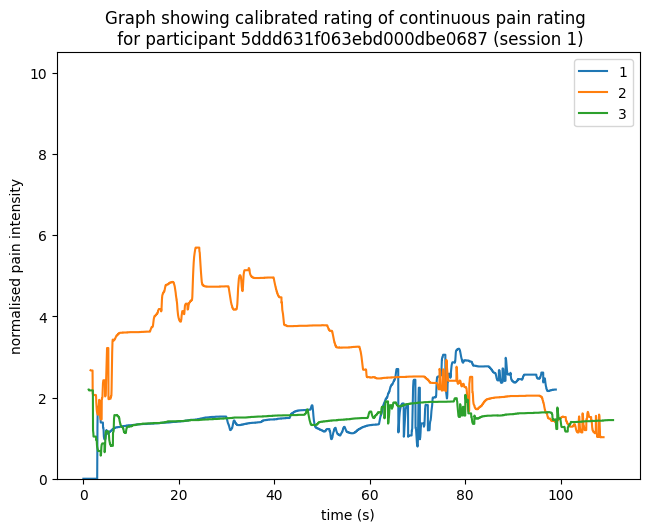

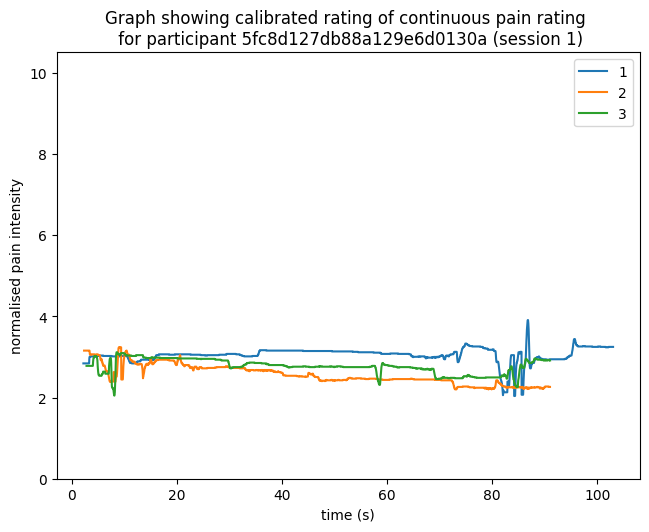

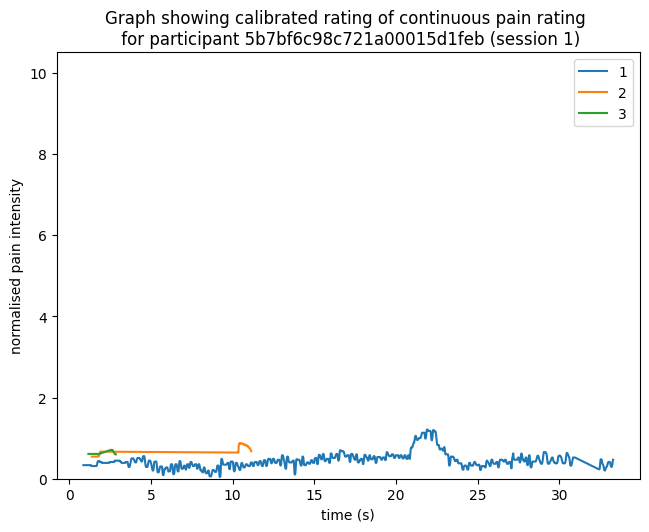

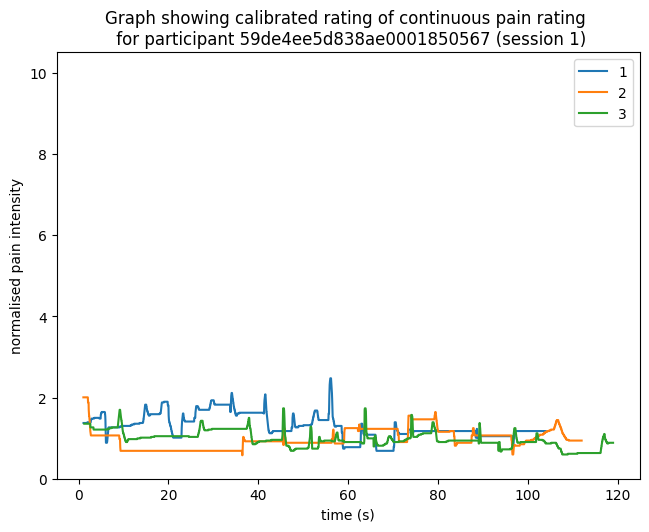

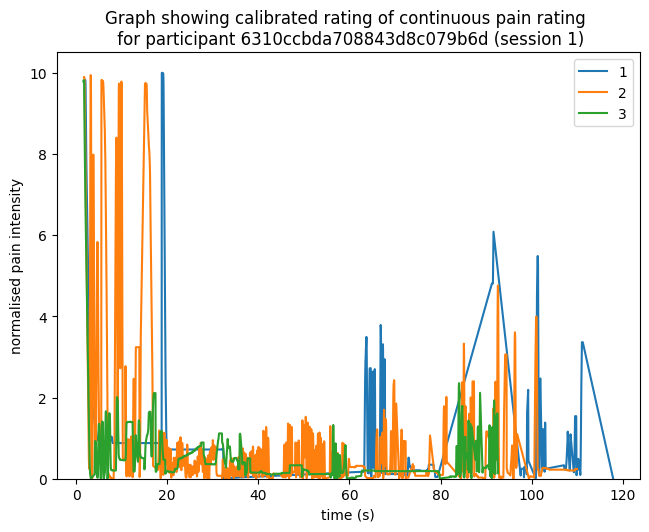

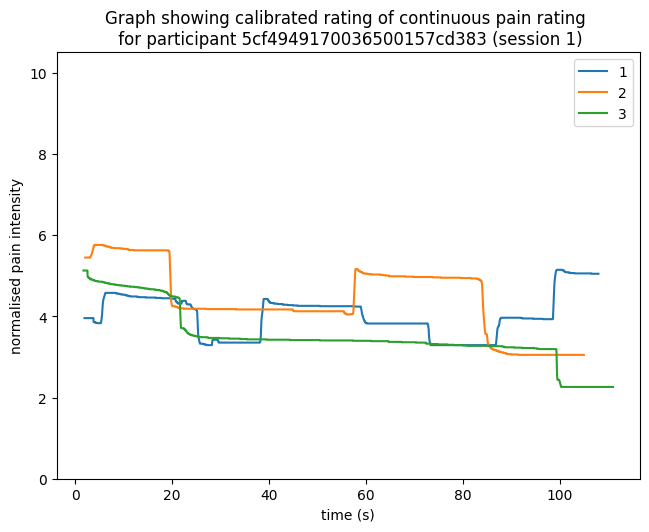

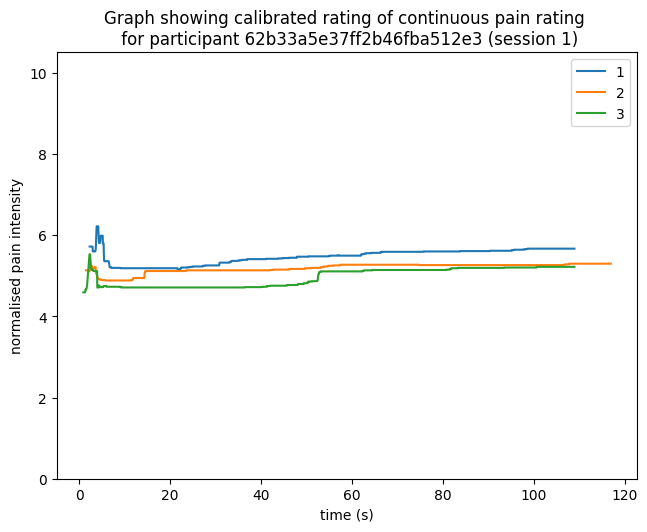

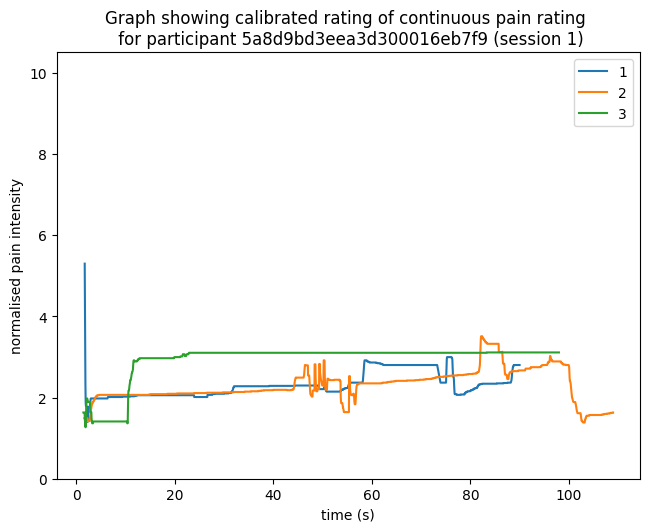

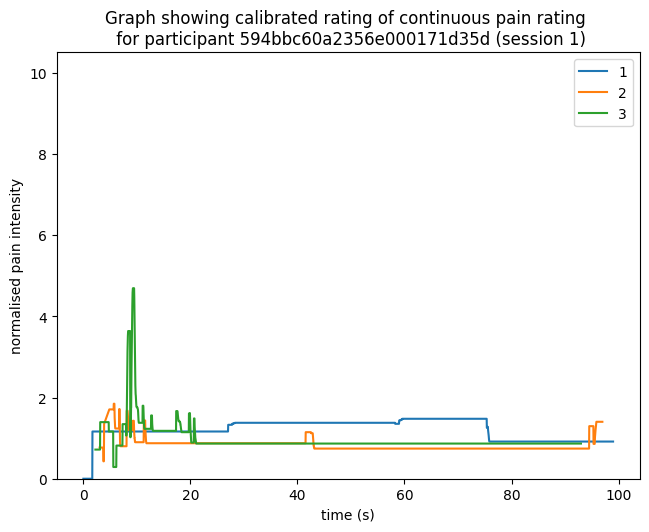

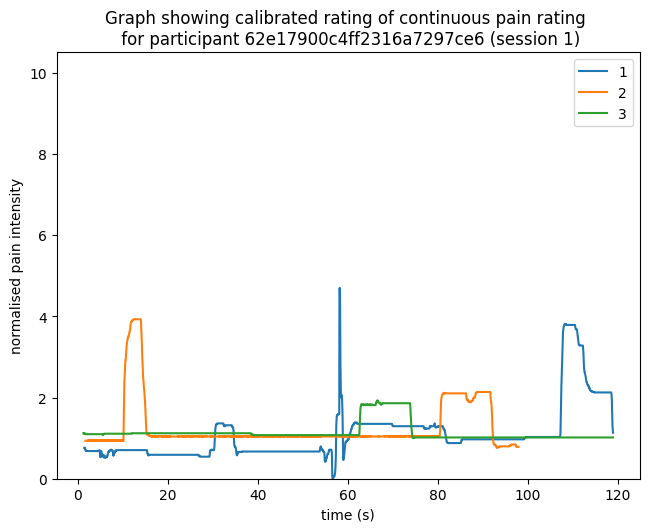

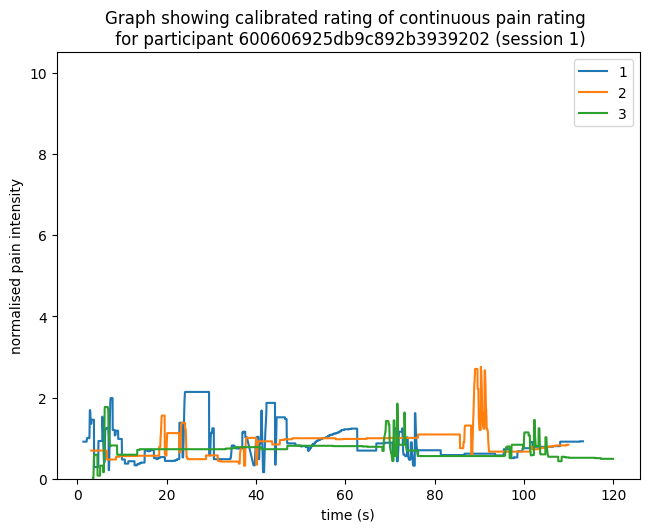

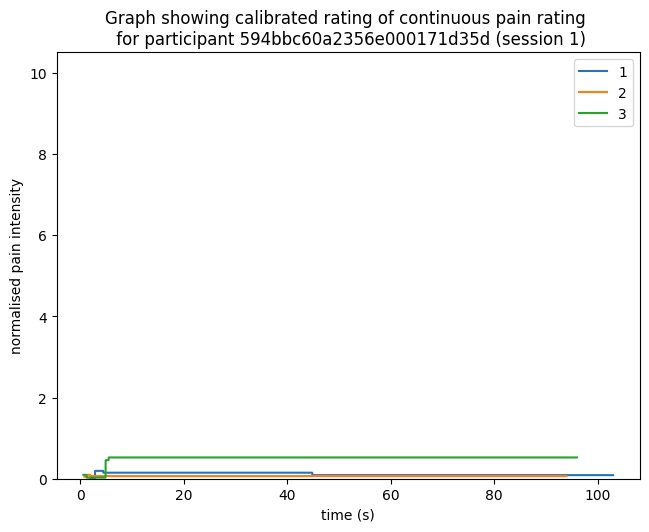

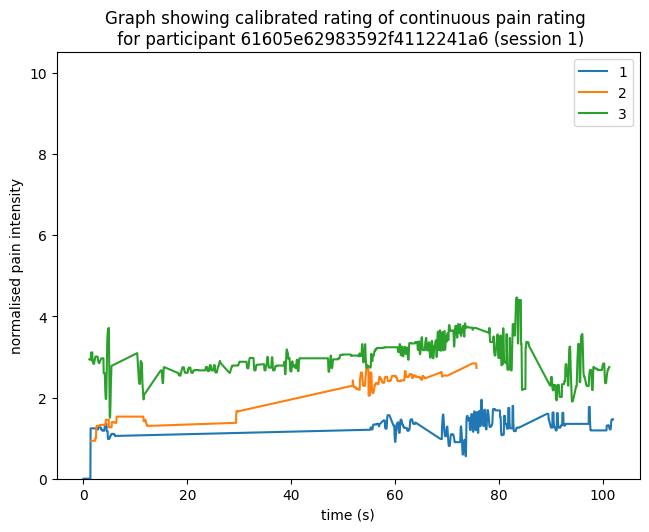

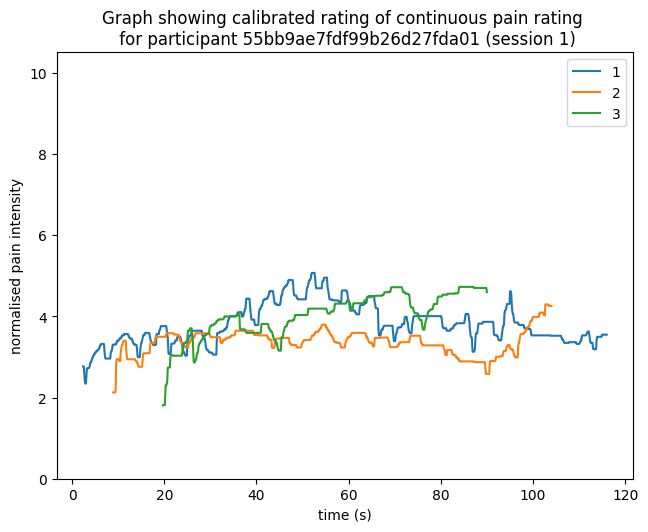

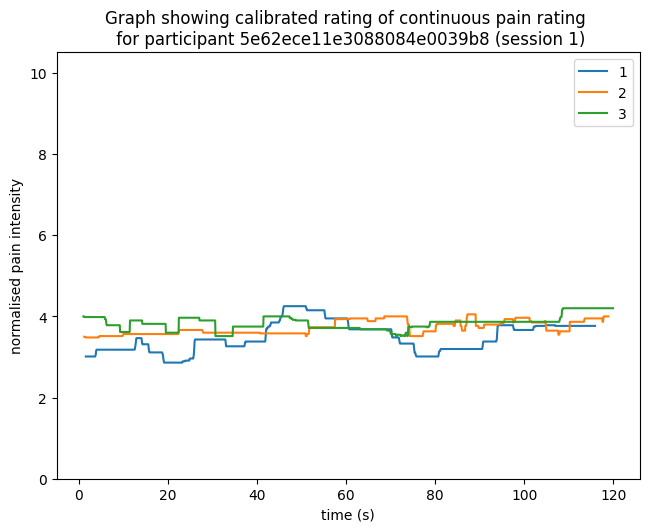

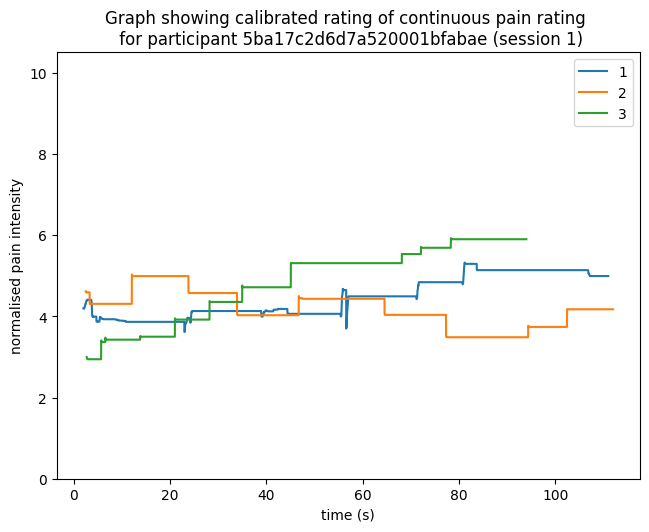

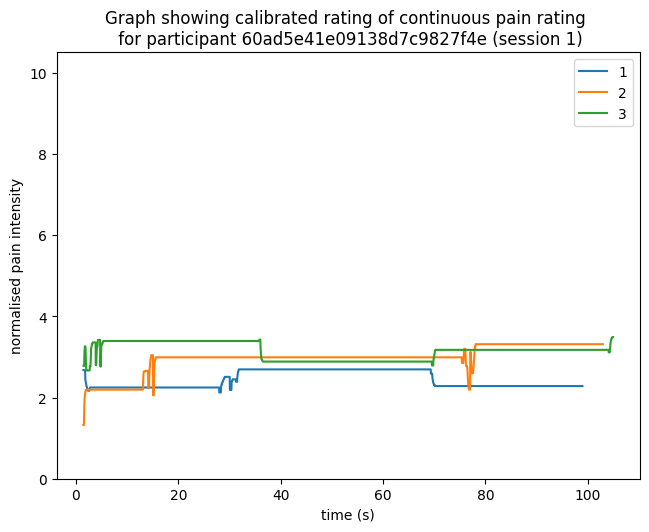

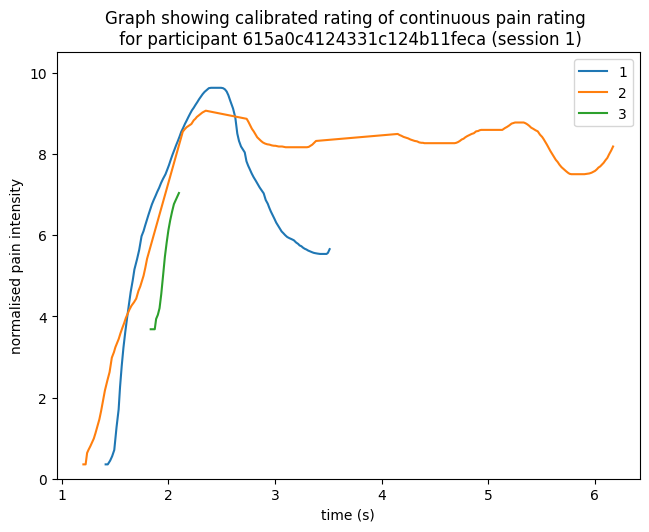

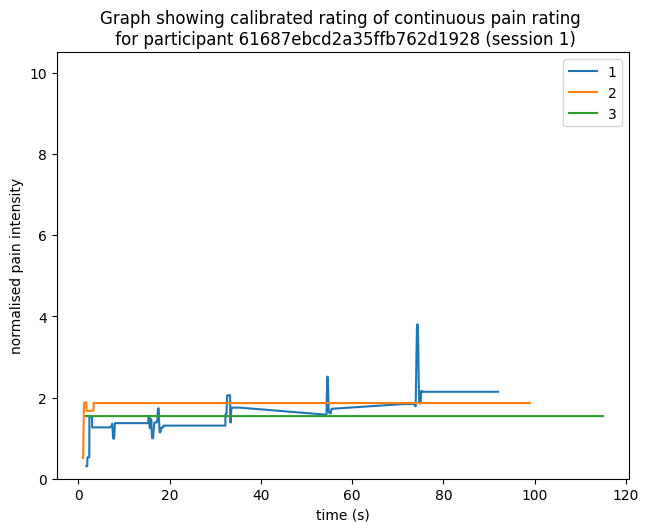

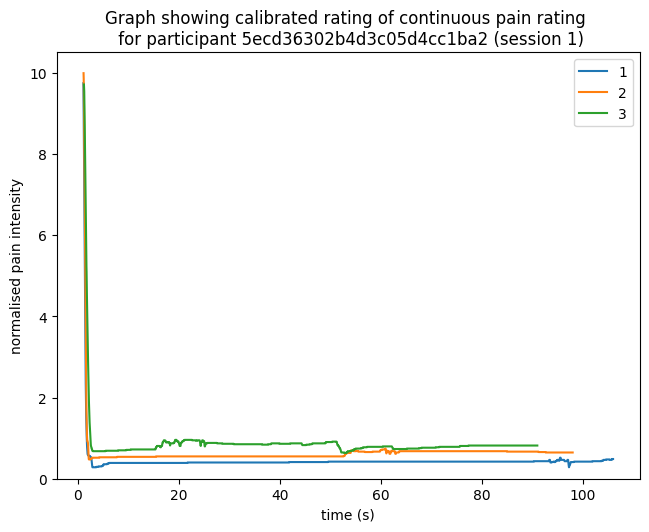

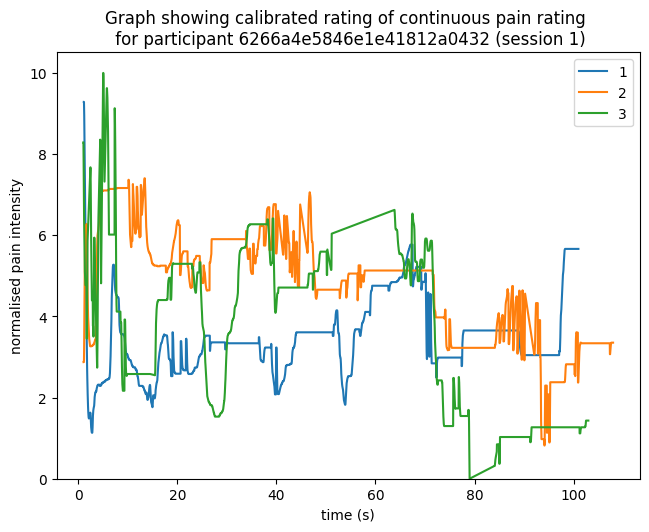

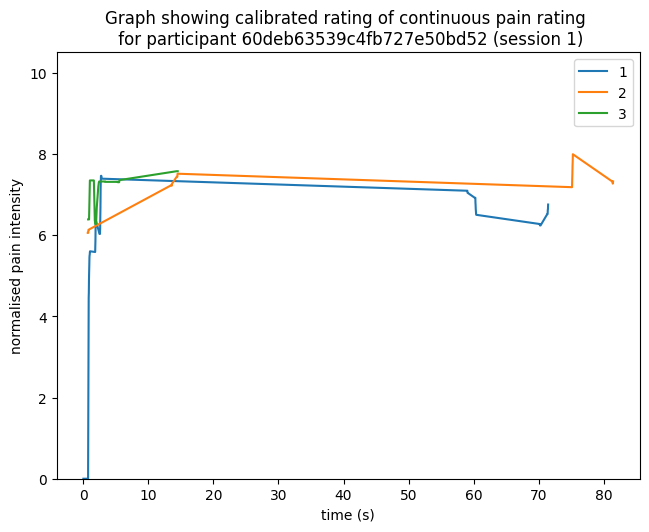

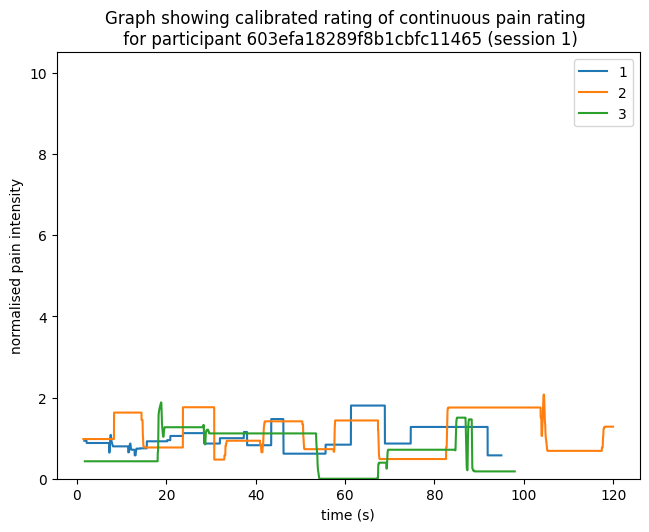

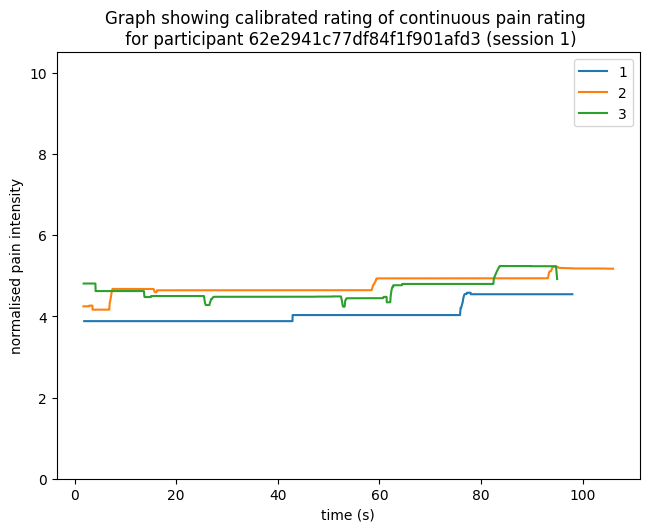

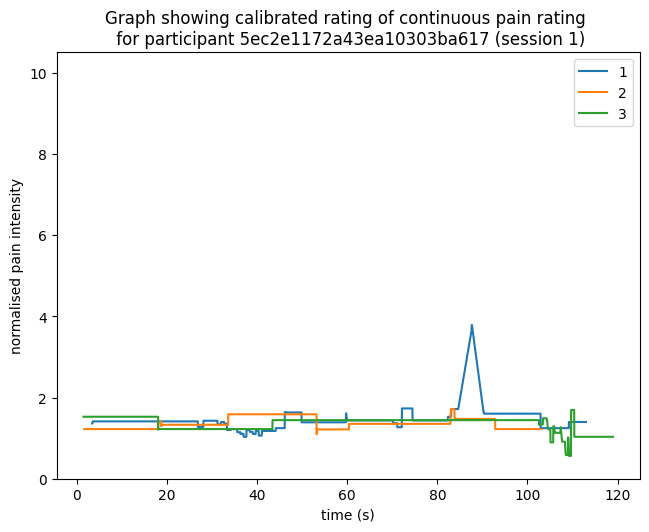

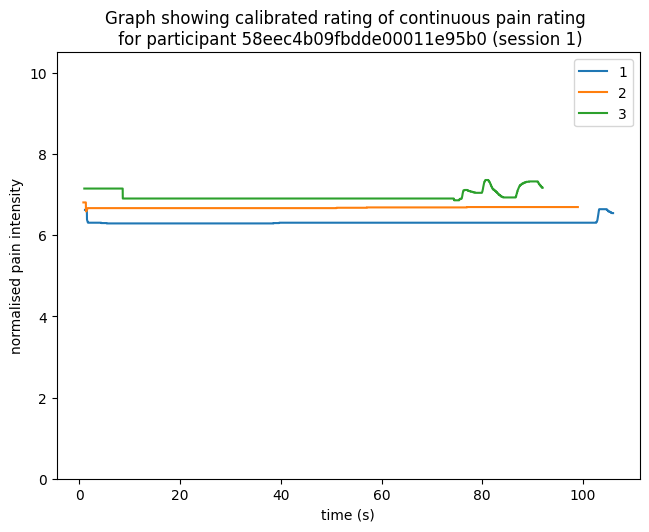

In [8]:
data_pos = [x for x in range(12)]
sessions = [0]
mouse_slider_rating_list_all = []
mouse_slider_time_list_all = []
for session in sessions:
    mouse_slider_rating_list_session = []
    mouse_slider_time_list_session = []
    for index in tqdm(range(len(files_first))):
        plt.figure()
        data = pd.read_csv(files_first[index])

        #obtain relevant data

        #mouse_slider_data = data['mouse_slider.y'][len(data)-1-loops:len(data)-1]
        mouse_slider_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_data.append([float(data['mouse_slider.y'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.y'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_data.append([np.nan])
        mouse_slider_time = data['mouse_slider.time']
        mouse_slider_time_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_time_data.append([float(data['mouse_slider.time'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.time'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_time_data.append([np.nan])
            #calibration (normalise)
        mouse_slider_rating_list = []
        mouse_slider_time_list = []
        mouse_top_position = data['mouse_slider.top'][8]
        mouse_bottom_position = data['mouse_slider.bottom'][8]
        max_number = []
        min_number = []
            #note the beginning of the first train always starts from below the bottom of the slider due to the artefact from the position of the start button so when normalising we ignore the data of the artefact hence the data is a bit out of range
        for i in range(0,len(mouse_slider_data)):
            max_number.append(max(mouse_slider_data[i]))
            min_number.append(min(mouse_slider_data[i]))
        if max(max_number) > mouse_top_position:
            mouse_top_position = max(max_number)
        if min(min_number) < mouse_bottom_position:
            mouse_bottom_position = min(min_number)
        continuous_length = mouse_top_position - mouse_bottom_position

        for i in range(len(mouse_slider_data)):
            mouse_slider_data_np = np.array(mouse_slider_data[i])
            mouse_slider_time_np = np.array(mouse_slider_time_data[i])
            mouse_slider_time_list.append(mouse_slider_time_np)
            mouse_slider_rating = (mouse_slider_data_np - mouse_bottom_position)/continuous_length*10
            mouse_slider_rating_list.append(mouse_slider_rating)
        mouse_slider_rating_list_session.append(mouse_slider_rating_list)
        mouse_slider_time_list_session.append(mouse_slider_time_list)
    

            #plot
        for i in range(len(mouse_slider_data)):
            plt.plot(mouse_slider_time_list[i], mouse_slider_rating_list[i], label = i+1)
            plt.ylim(0,10.5)
            plt.legend()
        plt.tight_layout()
        plt.title(f'Graph showing calibrated rating of continuous pain rating \n for participant {participant_id_first[index]} (session {session+1})')
        plt.xlabel('time (s)')
        plt.ylabel('normalised pain intensity')
    mouse_slider_rating_list_all.append(mouse_slider_rating_list_session)
    mouse_slider_time_list_all.append(mouse_slider_time_list_session)
    




  0%|          | 0/26 [00:00<?, ?it/s]

C:\Users\sharonho\AppData\Local\Temp\ipykernel_4060\1584228842.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


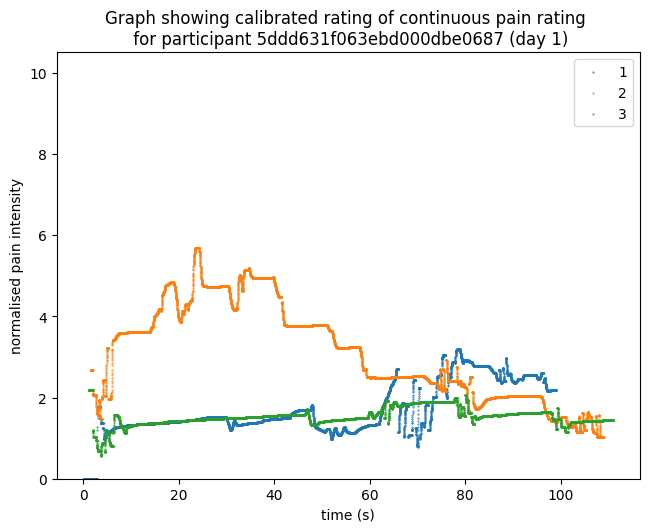

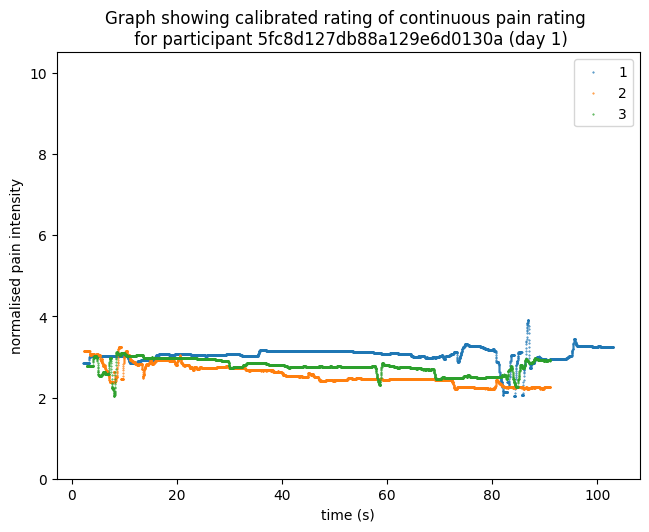

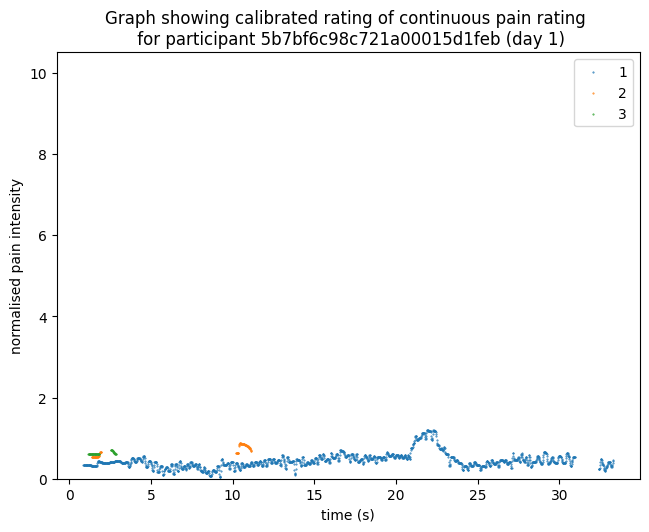

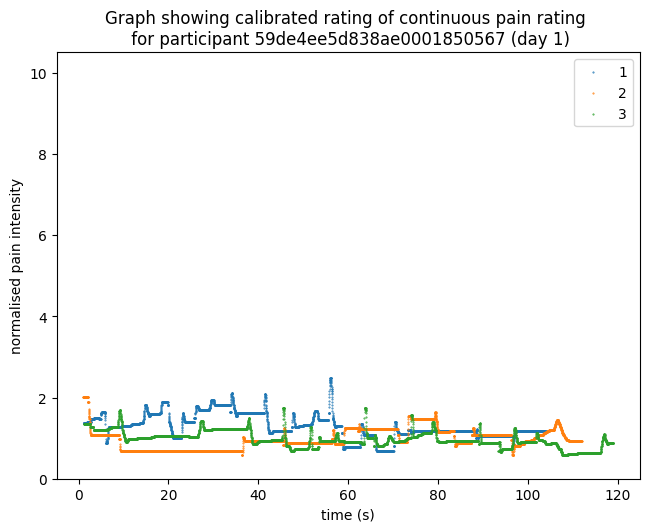

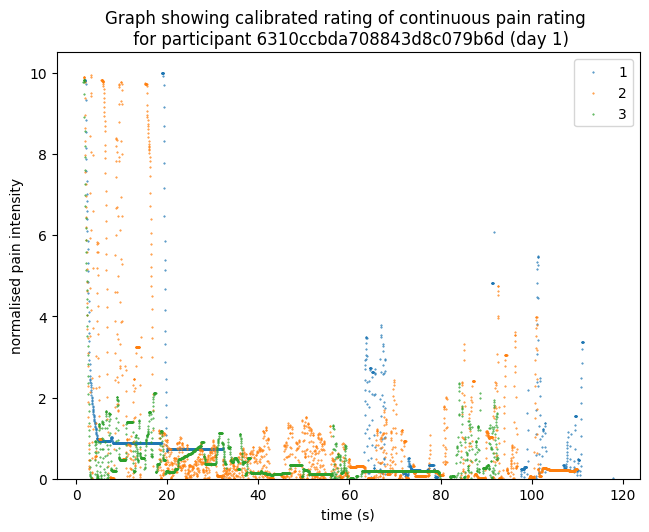

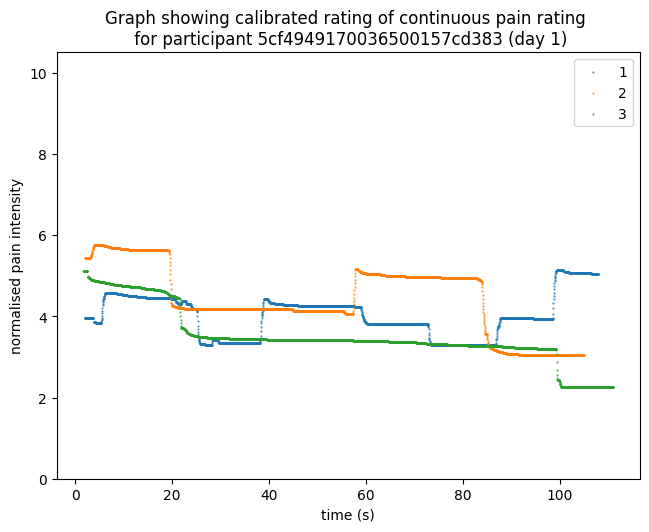

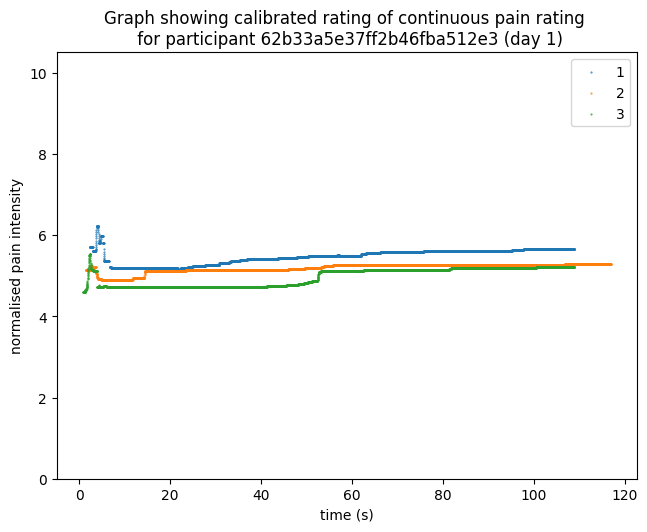

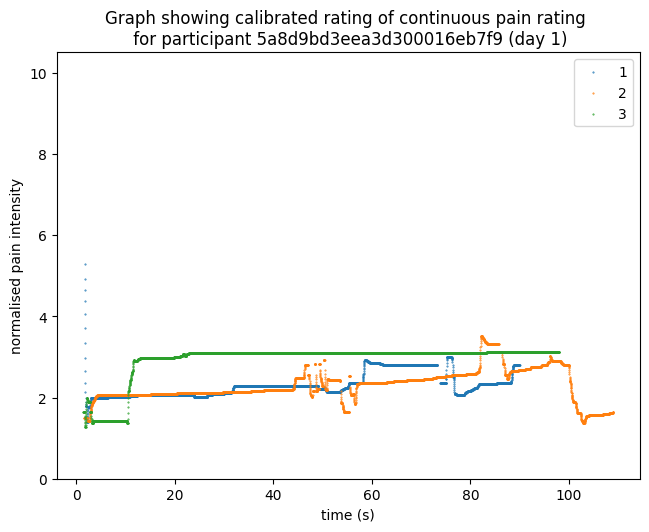

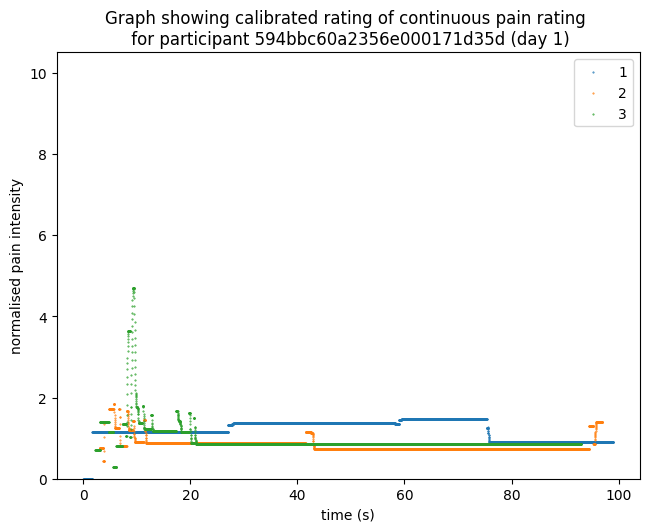

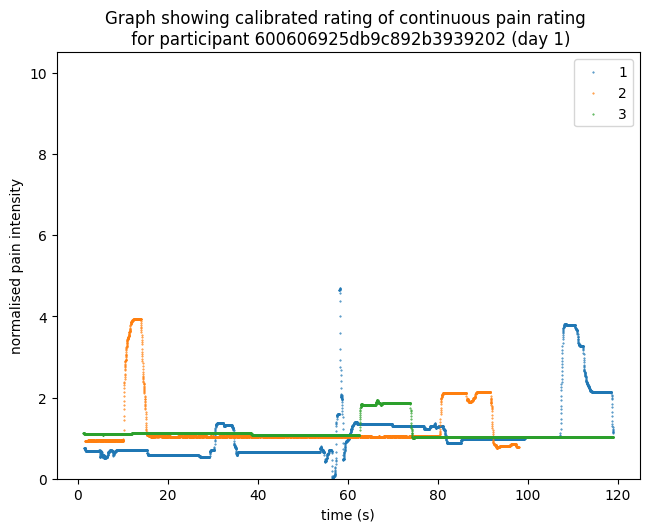

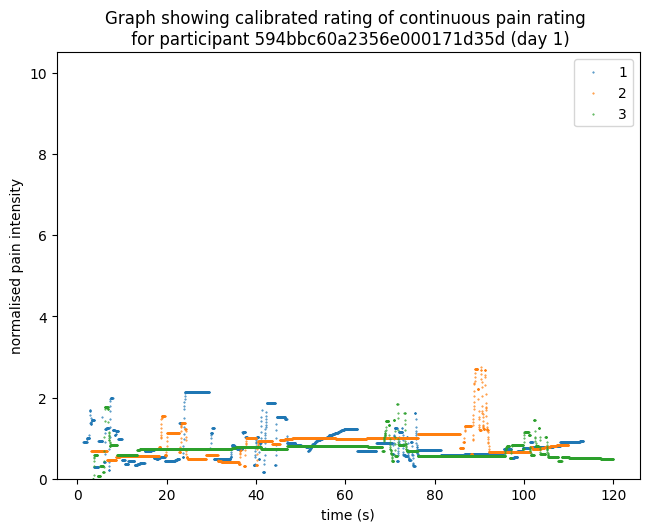

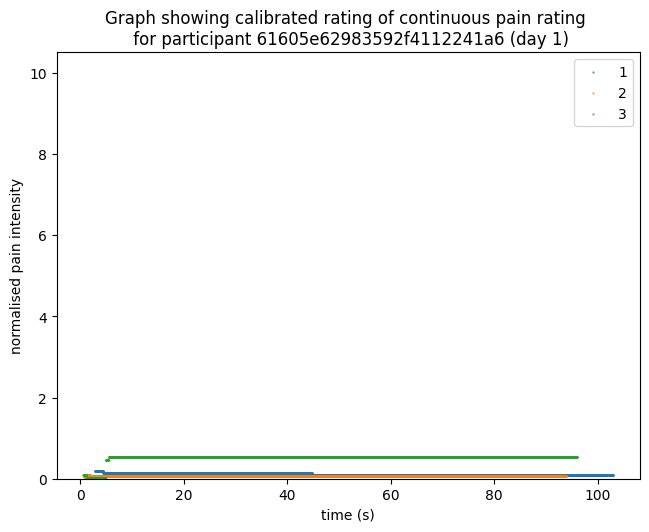

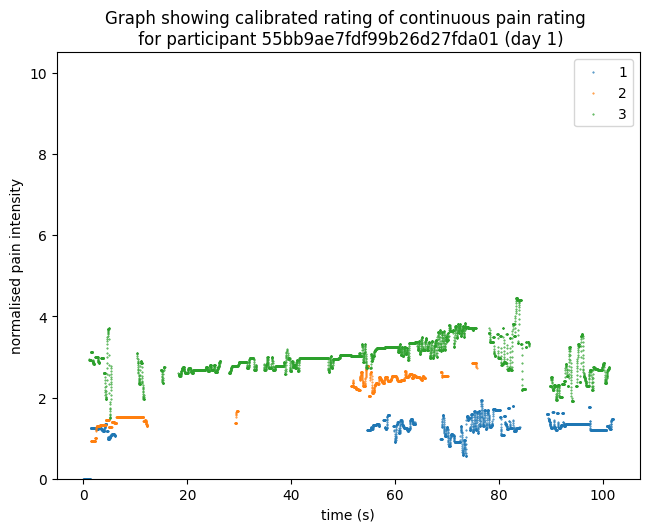

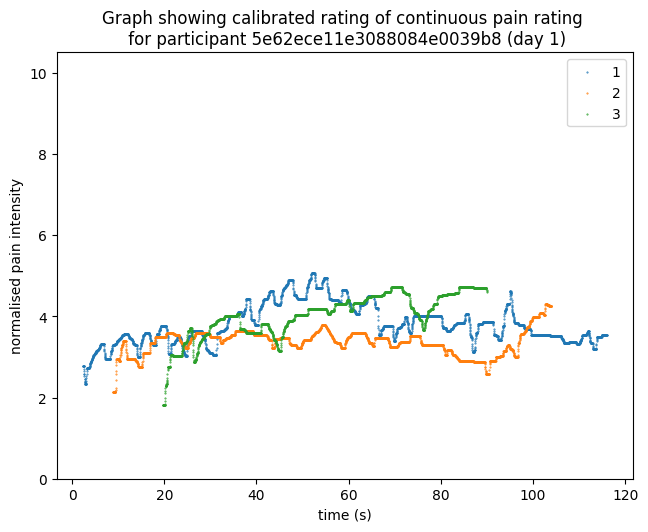

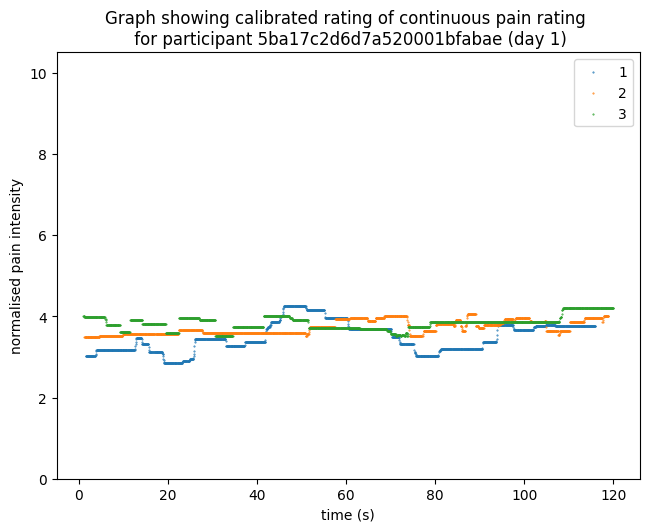

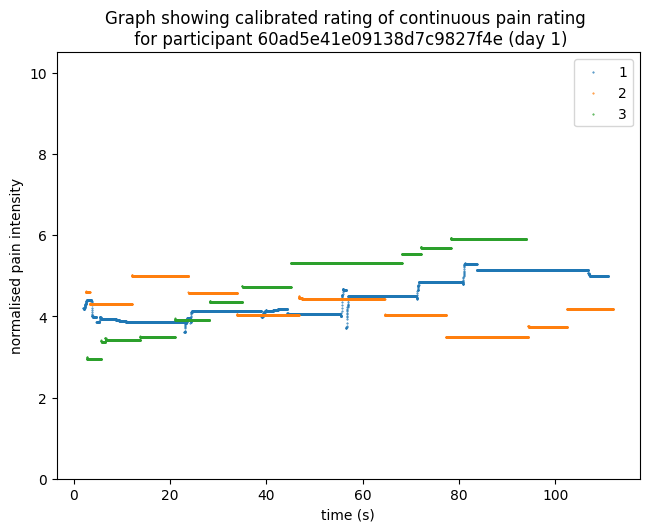

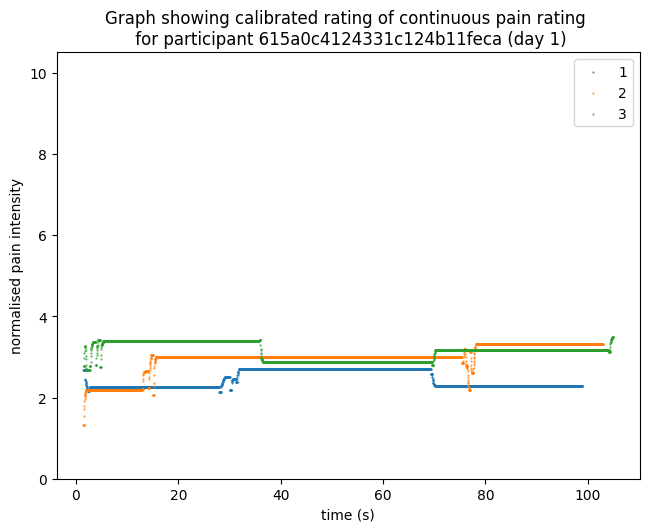

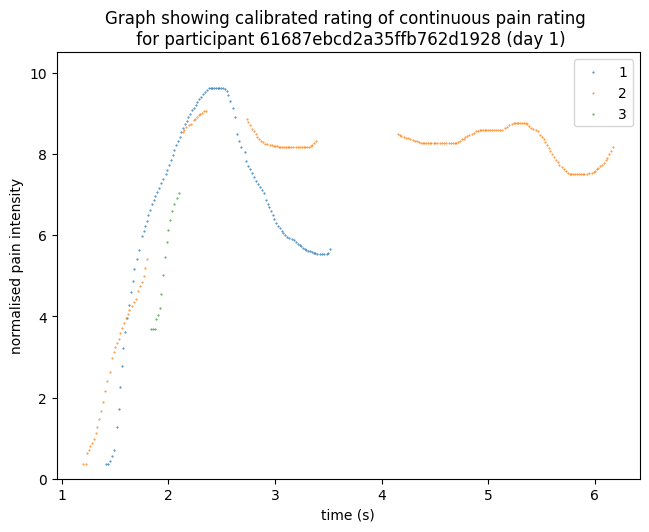

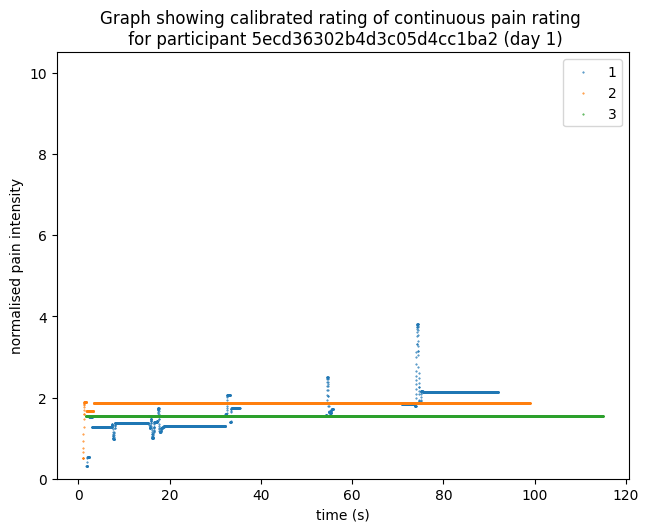

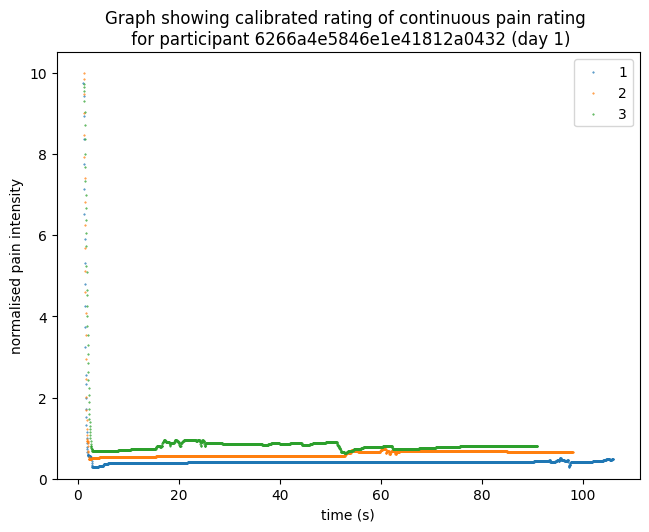

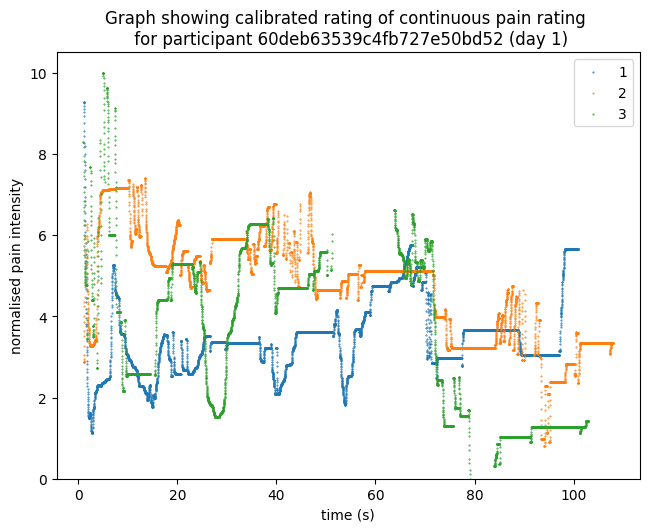

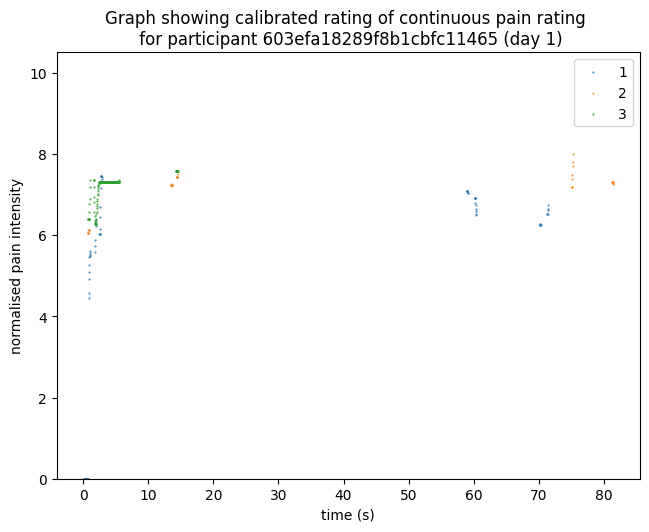

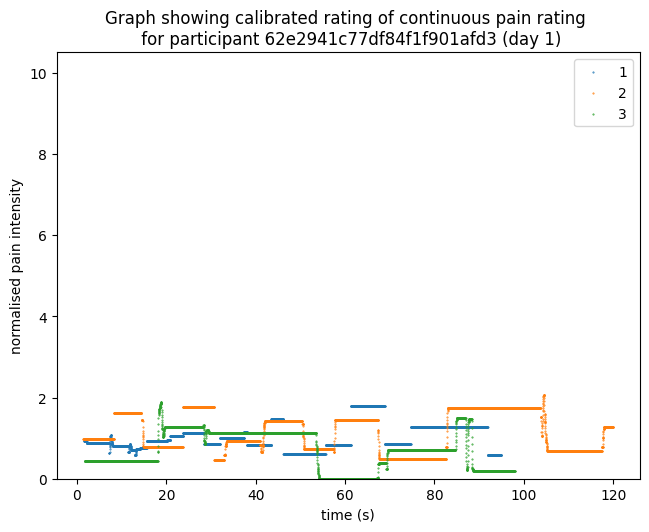

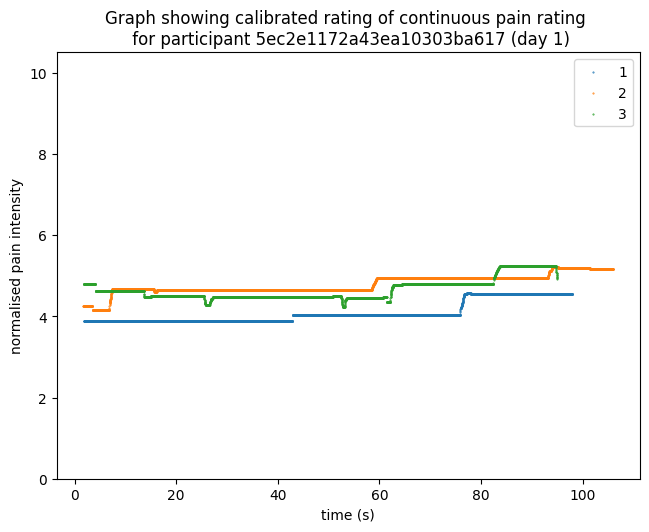

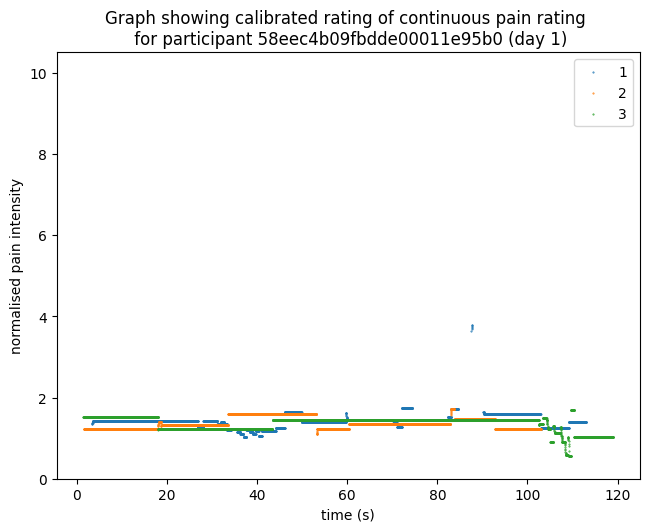

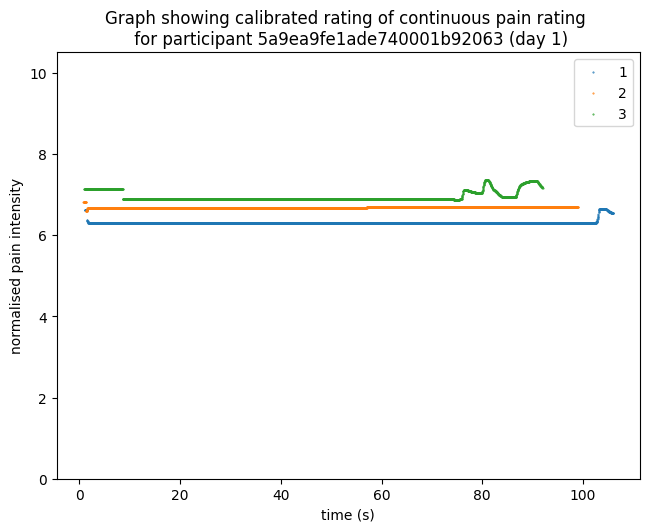

In [8]:
data_pos = [x for x in range(12)]
sessions = [0]
mouse_slider_rating_list_all = []
mouse_slider_time_list_all = []
for session in sessions:
    mouse_slider_rating_list_session = []
    mouse_slider_time_list_session = []
    for index in tqdm(range(len(files_first))):
        plt.figure()
        data = pd.read_csv(files_first[index])

        #obtain relevant data

        #mouse_slider_data = data['mouse_slider.y'][len(data)-1-loops:len(data)-1]
        mouse_slider_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_data.append([float(data['mouse_slider.y'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.y'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_data.append([np.nan])
        mouse_slider_time = data['mouse_slider.time']
        mouse_slider_time_data = []
        for j in data_pos:
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_time_data.append([float(data['mouse_slider.time'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.time'][j][1:-1].split(",")))])
            elif pd.isnull(data['mouse_slider.y'].iloc[j]):
                pass
            else:
                mouse_slider_time_data.append([np.nan])
            #calibration (normalise)
        mouse_slider_rating_list = []
        mouse_slider_time_list = []
        mouse_top_position = data['mouse_slider.top'][8]
        mouse_bottom_position = data['mouse_slider.bottom'][8]
        max_number = []
        min_number = []
            #note the beginning of the first train always starts from below the bottom of the slider due to the artefact from the position of the start button so when normalising we ignore the data of the artefact hence the data is a bit out of range
        for i in range(0,len(mouse_slider_data)):
            max_number.append(max(mouse_slider_data[i]))
            min_number.append(min(mouse_slider_data[i]))
        if max(max_number) > mouse_top_position:
            mouse_top_position = max(max_number)
        if min(min_number) < mouse_bottom_position:
            mouse_bottom_position = min(min_number)
        continuous_length = mouse_top_position - mouse_bottom_position

        for i in range(len(mouse_slider_data)):
            mouse_slider_data_np = np.array(mouse_slider_data[i])
            mouse_slider_time_np = np.array(mouse_slider_time_data[i])
            mouse_slider_time_list.append(mouse_slider_time_np)
            mouse_slider_rating = (mouse_slider_data_np - mouse_bottom_position)/continuous_length*10
            mouse_slider_rating_list.append(mouse_slider_rating)
        mouse_slider_rating_list_session.append(mouse_slider_rating_list)
        mouse_slider_time_list_session.append(mouse_slider_time_list)
    

            #plot
        for i in range(len(mouse_slider_data)):
            plt.scatter(mouse_slider_time_list[i], mouse_slider_rating_list[i], label = i+1, s = 0.2)
            plt.ylim(0,10.5)
            plt.legend()
        plt.tight_layout()
        plt.title(f'Graph showing calibrated rating of continuous pain rating \n for participant {participant_id_first[index]} (day {session+1})')
        plt.xlabel('time (s)')
        plt.ylabel('normalised pain intensity')
    mouse_slider_rating_list_all.append(mouse_slider_rating_list_session)
    mouse_slider_time_list_all.append(mouse_slider_time_list_session)
    




## Analysing the response of prediction and confidence

In [18]:
prediction_all = []
confidence_all= []
for session in sessions:
    
    prediction_session = []
    confidence_session = []
    for index in range(len(files[session])):   
        #plt.figure()
        data = pd.read_csv(files[session][index])
        if pd.isnull(data['pain_predict_slider.response']).all() == True:
                prediction_session.append(np.nan)
        for j in range(len(data)):
        #obtain relevant data
            if pd.isnull(data['pain_predict_slider.response'].iloc[j]):
                pass
            else:
                prediction = 10*data['pain_predict_slider.response'].iloc[j]
                prediction_session.append(prediction)
        if pd.isnull(data['confidence_slider_2.response']).all() == True:
                confidence_session.append(np.nan)
        for j in range(len(data)):
        #obtain relevant data
            if pd.isnull(data['confidence_slider_2.response'].iloc[j]):
                pass
            else:
                confidence = 10*data['confidence_slider_2.response'].iloc[j]
                confidence_session.append(confidence)
    prediction_all.append(prediction_session)
    confidence_all.append(confidence_session)





In [19]:
print(prediction_all)
#confidence_all
#participant_number
print(confidence_all)

[[2.0331997, 2.25616734, 0.44019666, 1.4167023200000002, 0.0, 2.99362933, 5.6414683, 3.3616081399999995, 0.9906131699999999, 0.9452332200000001, 1.4602963999999998, 0.47815799999999997, 2.23233196, nan, 3.69611737, 3.6963488900000003, 3.28168477, 6.4322634899999995, 2.25211279, 6.99298469, 1.16874251, 7.81981935, 0.83822271, 5.00122622, 1.5102490299999998, 5.74069659]]
[[5.6781684, 8.122434179999999, 8.70740891, 7.34339278, 9.05187093, 2.55310287, 7.23865056, 2.5010412300000002, 7.64212828, 7.55632779, 9.89379425, 9.676870749999999, 7.57705123, 0.31445230999999996, 8.5415794, 7.198511239999999, 3.95876718, 8.47511454, 9.308100790000001, 8.26633453, 10.0, 8.64431487, 0.35535064, 7.06161194, 8.706227890000001, 5.156184919999999]]


o	Evaluate difference between the PE values statistically

o	Pearson’s correlation coefficient to test the relationship between the PE values and pain levels?
